VGG16 Model with Augmentation/Pre-processing. Removed Disgust and Standardized the Number of Images per Category

In [77]:
%matplotlib inline

import numpy as np
import os
import matplotlib.pylab as plt
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
import random
import shutil
from keras.applications.vgg16 import VGG16
from keras import optimizers

In [69]:

# Image directories for training and testing
trainEmotions = '/Users/kaylienguyen/Downloads/FER_dataset/trainrevised_nodisgust'
testEmotions = '/Users/kaylienguyen/Downloads/FER_dataset/testrevised_nodisgust'

# train_subdirectories = [subdir for subdir in os.listdir(trainEmotions) if subdir != 'disgust']
# test_subdirectories = [subdir for subdir in os.listdir(testEmotions) if subdir != 'disgust']

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, zoom_range=0.3, horizontal_flip=True)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

IMAGE_SIZE = (48, 48)
BATCH_SIZE = 64

train_generator = train_datagen.flow_from_directory(
    directory=trainEmotions,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    #classes=train_subdirectories
    )

test_generator = test_datagen.flow_from_directory(
    directory=testEmotions,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False,
    #classes=test_subdirectories
    )




Found 28179 images belonging to 6 classes.
Found 6961 images belonging to 6 classes.


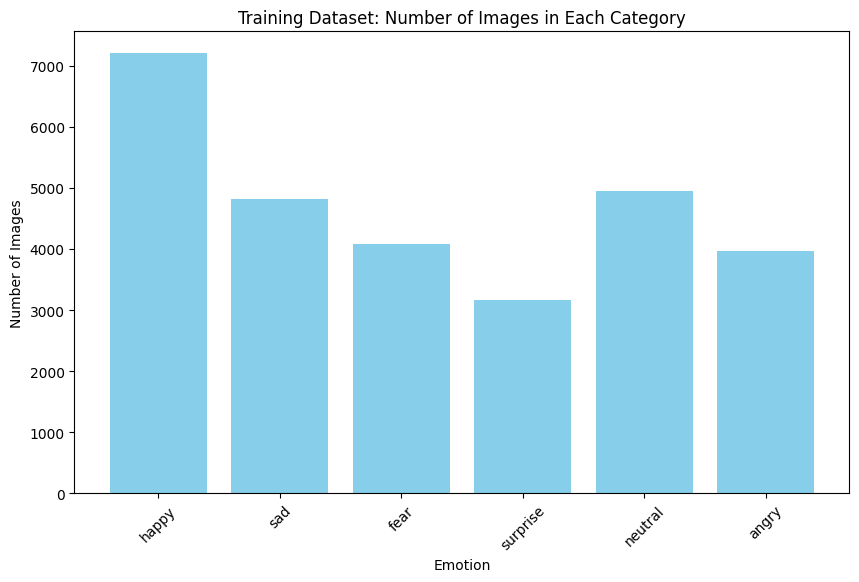

In [70]:
#Bar plot of distribution of test images in each emotion category
train_subdirectories = [subdir for subdir in os.listdir(trainEmotions) if subdir != 'disgust' and os.path.isdir(os.path.join(trainEmotions, subdir))]

image_counts = {}

for category in train_subdirectories:
    category_dir = os.path.join(trainEmotions, category)
    num_images = len(os.listdir(category_dir))
    image_counts[category] = num_images

plt.figure(figsize=(10, 6))
plt.bar(image_counts.keys(), image_counts.values(), color='skyblue')
plt.title('Training Dataset: Number of Images in Each Category')
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

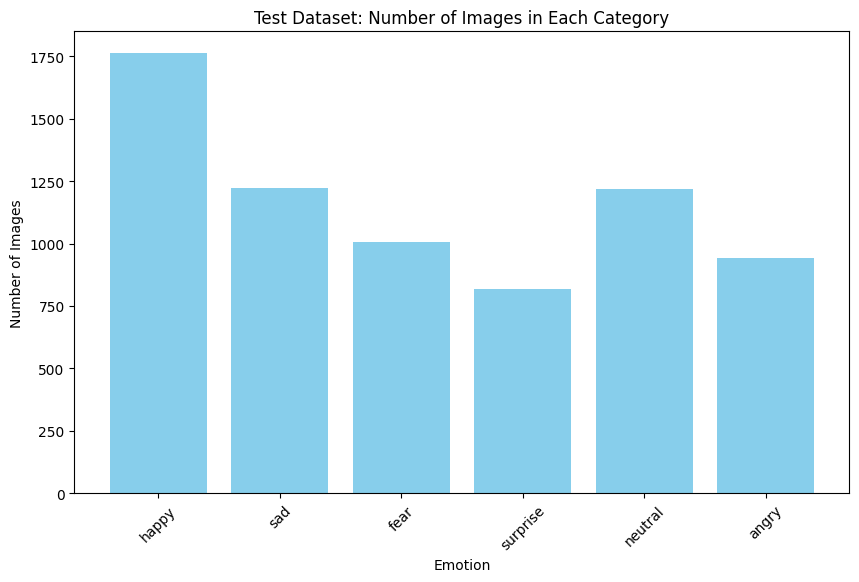

In [71]:
#Bar plot of distribution of test images in each emotion category
test_subdirectories = [subdir for subdir in os.listdir(testEmotions) if subdir != 'disgust' and os.path.isdir(os.path.join(testEmotions, subdir))]

image_counts = {}

for category in test_subdirectories:
    category_dir = os.path.join(testEmotions, category)
    num_images = len(os.listdir(category_dir))
    image_counts[category] = num_images

plt.figure(figsize=(10, 6))
plt.bar(image_counts.keys(), image_counts.values(), color='skyblue')
plt.title('Test Dataset: Number of Images in Each Category')
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [73]:
#Standardizing/equalizing the number of training and testing images per emotion category

train_image_counts = {}
test_image_counts = {}

for category in train_subdirectories:
    category_dir = os.path.join(trainEmotions, category)
    num_images = len(os.listdir(category_dir))
    train_image_counts[category] = num_images

#print(train_image_counts)

#{'happy': 7201, 'sad': 4824, 'fear': 4078, 'surprise': 3165, 'neutral': 4952, 'angry': 3965}
min_count_per_category = min(train_image_counts.values())       #this variable equals 3165 (surprise)
#print(min_count_per_category)




{'happy': 7201, 'sad': 4824, 'fear': 4078, 'surprise': 3165, 'neutral': 4952, 'angry': 3965}
3165


In [74]:
#creating a new folder that will not have disgust and will have an equal number of training images per emotion
source_dir = '/Users/kaylienguyen/Downloads/FER_dataset/trainrevised_nodisgust'
destination_dir = '/Users/kaylienguyen/Downloads/FER_dataset/trainrevised_balanced'

if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

categories = [category for category in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, category))]

num_images_per_category = min_count_per_category


for category in categories:
    
    category_images = os.listdir(os.path.join(source_dir, category))
    random.shuffle(category_images)
    selected_images = category_images[:num_images_per_category]
    
    category_destination_dir = os.path.join(destination_dir, category)
    os.makedirs(category_destination_dir, exist_ok=True)
    
    for image in selected_images:
        source_path = os.path.join(source_dir, category, image)
        destination_path = os.path.join(category_destination_dir, image)
        shutil.copyfile(source_path, destination_path)

print("Images copied successfully.")

Images copied successfully.


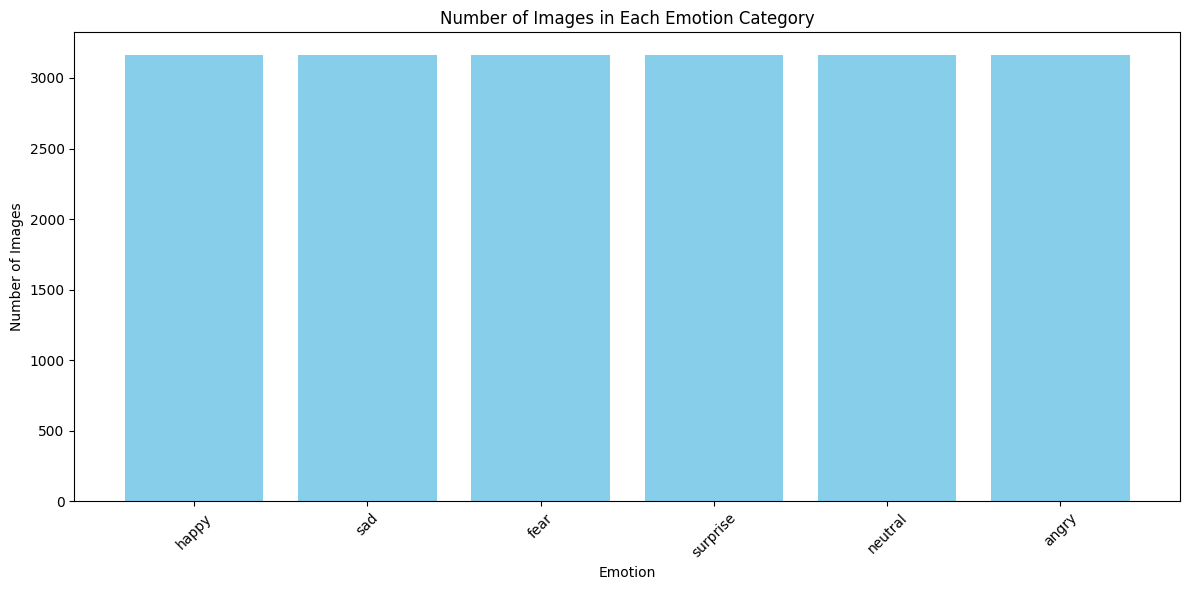

In [75]:
#showing that there is the same number of training images per emotion; 3165 per emotion

balanced_dir = '/Users/kaylienguyen/Downloads/FER_dataset/trainrevised_balanced'

image_counts = {}

for category in os.listdir(balanced_dir):
    category_dir = os.path.join(balanced_dir, category)
    num_images = len(os.listdir(category_dir))
    image_counts[category] = num_images


plt.figure(figsize=(12, 6))
plt.bar(image_counts.keys(), image_counts.values(), color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.title('Training Set: Number of Images in Each Emotion Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [76]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, zoom_range=0.3, horizontal_flip=True)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

TRAIN_DATA_PATH = '/Users/kaylienguyen/Downloads/FER_dataset/trainrevised_balanced'
TEST_DATA_PATH = '/Users/kaylienguyen/Downloads/FER_dataset/testrevised_nodisgust'
IMAGE_SIZE = (48, 48)
BATCH_SIZE = 64

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False)

Found 18984 images belonging to 6 classes.
Found 6961 images belonging to 6 classes.


In [78]:
input_shape = (48, 48, 1)
epochs = 40
conv_base = VGG16(weights='imagenet',
                include_top=False,
                input_shape=(48, 48, 3))
conv_base.trainable = False

model = Sequential([
    Conv2D(filters=10, kernel_size=3, strides=(1, 1), padding='valid', activation='relu', input_shape=input_shape, kernel_regularizer=l2(.01)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    BatchNormalization(),
    Conv2D(filters=20, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dense(512, activation = 'relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(7, activation='softmax')
])

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizers.Adam(lr=1e-4))
model.fit(
    train_generator,
    epochs=epochs,
    batch_size=64,
    validation_split=0.2,
    validation_data = test_generator  
)


test_loss, test_accuracy = model.evaluate_generator(test_generator)
print('Test Loss: ', test_loss)
print("Test Accuracy:", test_accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

confusion_mtx = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_mtx, display_labels = emotion_labels)
disp.plot()
plt.show()